# Simplify network topology and consolidate intersections

In [2]:
import networkx as nx
import osmnx as ox

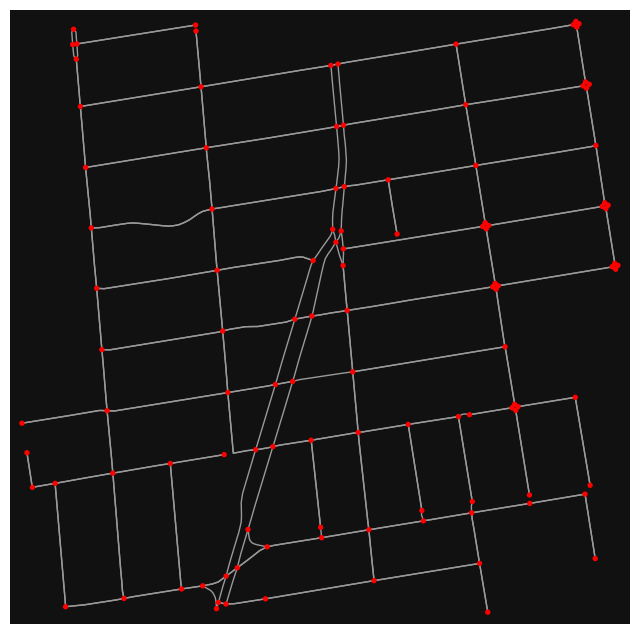

In [4]:
# get a street network and plot it with all edge intersections
point = 37.858495, -122.267468
G = ox.graph.graph_from_point(point, network_type="drive", dist=500)
fig, ax = ox.plot.plot_graph(G, node_color="r")

Try simplifying this graph by combining nodes within 15m buffers, also the dead-ends would not be returned

In [5]:
# get a GeoSeries of consolidated intersections
G_proj = ox.projection.project_graph(G)
ints = ox.simplification.consolidate_intersections(
    G_proj, rebuild_graph=False, tolerance=15, dead_ends=False
)
len(ints)

66

In [6]:
len(G)

113

Comparing the node in original graph and cleaned up graph, we can see a large number of nodes has been droped.

Then we rebuilt the graph

In [8]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.simplification.consolidate_intersections(
    G_proj, rebuild_graph=True, tolerance=15, dead_ends=False
)

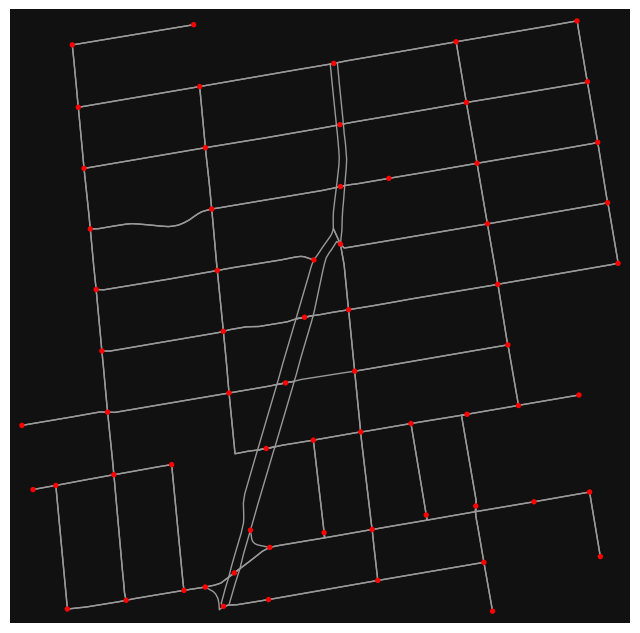

In [9]:
fig, ax = ox.plot.plot_graph(G2, node_color="r")

Running consolidate_intersections with rebuild_graph=True may yield somewhat (but not very) different intersection counts/densities compared to rebuild_graph=False. The difference lies in that the latter just merges buffered node points that overlap, whereas the former checks the topology of the overlapping node buffers before merging them.

This prevents topologically remote but spatially proximate nodes from being merged. For example:

- A street intersection may lie directly below a freeway overpass's intersection with an on-ramp. We would not want to merge these together and connnect their edges: they are distinct junctions in the system of roads.
- In a residential neighborhood, a bollarded street may create a dead-end immediately next to an intersection or traffic circle. We would not want to merge this dead-end with the intersection and connect their edges.

These examples illustrate (two-dimensional) geometric proximity, but topological remoteness. Accordingly, in some situations we may expect higher intersection counts when using rebuild_graph=True because it is more cautious with merging in these cases. The trade-off is that it has higher time complexity than rebuild_graph=False